# Mantel-Haenszel検定に関するノート

$
\newcommand\ds{\displaystyle}
$

In [1]:
using Distributions
using StatsPlots
default(fmt = :png)
using Roots
using Optim
using Memoization

safediv(x, y) = x == 0 ? x/one(y) : x/y
safesqrt(x) = √max(0, x)

safesqrt (generic function with 1 method)

## オッズ比が1以外の場合に拡張されたMantel-Haenszel検定のP値函数

オッズ比が1以外の場合に拡張されたMantel-Haenszel検定のP値函数は以下のようにして構成可能である(導出は独自).

「共通のオッズ比は $\omega$ である」という仮説のP値函数を構成しよう.

$i = 1,2,\ldots,r$ について, $i$ 番目の2×2の分割表を

$$
\begin{bmatrix}
a_i & b_i \\
c_i & d_i \\
\end{bmatrix}
$$

と書き,

$$
N_i = a_i + b_i + c_i + d_i
$$

とおく.  共通のオッズ比を $\omega > 0$ と書く.

(1) 統計量 $\delta_i$ を

$$
\frac{(a_i - \delta_i)(d_i - \delta_i)}{(b_i + \delta_i)(c_i + \delta_i)} = \omega, \quad
-\min(b,c) < \delta_i < \min(a,d)
$$

という条件によって $\delta_i$ を定める. すなわち

$$
A_i = 1 - \omega, \quad
B_i = a_i + d_i + \omega(b_i + c_i), \quad
C_i = a_i d_i - \omega b_i c_i
$$

とおくと,

$$
\delta_i = \frac{2C_i}{B_i + \sqrt{B_i^2 - 4A_i C_i}}.
$$

これは2次方程式 $A_i x^2 - B_i x + C_i = 0$ の解の1つである.  例えば, $\omega = 1$ のとき

$$
\delta_i = a_i - \frac{(a_i+b_i)(a_i+c_i)}{N_i} = \frac{a_i d_i - b_i c_i}{N_i}
$$

(2) 統計量 $v_i$ を

$$
v_i = 
\frac{N_i}{N_i-1}
\left(\frac{1}{a_i-\delta_i} + \frac{1}{b_i+\delta_i} + \frac{1}{c_i+\delta_i} + \frac{1}{d_i-\delta_i}\right)^{-1}
$$

と定める.  例えば, $\omega = 1$ のとき, $v_i$ は超幾何分布の分散に一致する:

$$
v_i = \frac{(a_i+b_i)(c_i+d_i)(a_i+c_i)(b_i+d_i)}{N_i^2(N_i - 1)}.
$$

(3) 統計量 $Z^2$ を次のように定める:

$$
Z^2 = \frac{\left(\sum_{i=1}^r \delta_i\right)^2}{\sum_{i=1}^r v_i}
$$

例えば, $\omega = 1$ のとき, これは次のようにMantel-Haenszelのχ²統計量に一致する:

$$
Z^2 =
\frac
{\left(\sum_{i=1}^r (a_i - (a_i+b_i)(a_i+c_i)/N_i)\right)^2}
{\sum_{i=1}^r (a_i+b_i)(c_i+d_i)(a_i+c_i)(b_i+d_i)/(N_i^2(N_i-1))}.
$$

さらに $r=1$ とすると, 

$$
Z^2 = \frac{(N_1 - 1)(a_1 d_1 - b_1 c_1)^2}{(a_1+b_1)(c_1+d_1)(a_1+c_1)(b_1+d_1)}.
$$

これは単独の2×2の分割表の独立性検定のPearsonのχ²統計量の $(N_1 - 1)/N_1$ 倍に一致する.

(4) P値を自由度 $1$ のχ²分布で $Z^2$ 以上になる確率と定める.

In [2]:
function delta_oddsratio(a, b, c, d, ω = 1.0)
    A = 1 - ω
    B = a + d + ω*(b + c)
    C = a*d - ω*b*c
    # δ = solution of Ax² - Bx + C = 0 with −min(b,c) < x < min(a,d)
    # Then δ is uniquely charactrized by
    # (a - δ)(d - δ)/((b + δ)(c + δ)) = ω and −min(b,c) < x < min(a,d)
    δ = safediv(2C, B + safesqrt(B^2 - 4*A*C))
end

function vardelta_oddsratio(a, b, c, d, ω = 1.0)
    N = a + b + c + d
    δ = delta_oddsratio(a, b, c, d, ω)
    varδ = (N - 1)/N/(1/(a - δ) + 1/(b + δ) + 1/(c + δ) + 1/(d - δ))
end

function sumdelta_oddsratio(a, b, c, d, ω = 1.0)
    sumδ = sum(((a, b, c, d),) -> delta_oddsratio(a, b, c, d, ω), zip(a, b, c, d))
end

function sumdelta_oddsratio(tbl::Matrix, ω = 1.0)
    @views a, b, c, d = tbl[:,1], tbl[:,2], tbl[:,3], tbl[:,4]
    sumδ = sumdelta_oddsratio(a, b, c, d, ω)
end

function sumdelta_oddstatio(tbl::Array{T, 3} where T, ω = 1.0)
    @views a, b, c, d = tbl[:,1,1], tbl[:,2,1], tbl[:,2,1], tbl[:,2,2]
    sumδ = sumdelta_oddstatio(a, b, c, d, ω)
end

function sumvardelta_oddsratio(a, b, c, d, ω = 1.0)
    sumvarδ = sum(((a, b, c, d),) -> vardelta_oddsratio(a, b, c, d, ω), zip(a, b, c, d))
end

function sumvardelta_oddsratio(tbl::Matrix, ω = 1.0)
    @views a, b, c, d = tbl[:,1], tbl[:,2], tbl[:,3], tbl[:,4]
    sumvarδ = sumvardelta_oddsratio(a, b, c, d, ω)
end

function sumvardelta_oddsratio(tbl::Array{T, 3} where T, ω = 1.0)
    @views a, b, c, d = tbl[:,1,1], tbl[:,2,1], tbl[:,2,1], tbl[:,2,2]
    sumvarδ = sumvardelta_oddsratio(a, b, c, d, ω)
end

function zsqstat_oddsratio(a, b, c, d, ω = 1.0)
    zsq = safediv(sumdelta_oddsratio(a, b, c, d, ω)^2, sumvardelta_oddsratio(a, b, c, d, ω))
end

function zsqstat_oddsratio(tbl::Matrix, ω = 1.0)
    @views a, b, c, d = tbl[:,1], tbl[:,2], tbl[:,3], tbl[:,4]
    zsq = zsqstat_oddsratio(a, b, c, d, ω)
end

function zsqstat_oddsratio(tbl::Array{T, 3} where T, ω = 1.0)
    @views a, b, c, d = tbl[:,1,1], tbl[:,2,1], tbl[:,2,1], tbl[:,2,2]
    zsq = zsqstat_oddsratio(a, b, c, d, ω)
end

function minimizer_zsqstat_oddsratio(tbl)
    f(t) = zsqstat_oddsratio(tbl, exp(t))
    o = optimize(f, -1e1, 1e1)
    OR = exp(Optim.minimizer(o))
end

function root_sumdelta_oddsratio(tbl)
    f(t) = sumdelta_oddsratio(tbl, exp(t))
    logOR = find_zero(f, 0.0, Order2())
    OR = exp(logOR)
end

function pval_mantelhaenszel_oddsratio(tbl, ω = 1.0)
    Z² = zsqstat_oddsratio(tbl, ω)
    p_value = ccdf(Chisq(1), Z²)
end

function ci_mantelhaenszel_oddsratio(tbl, α = 0.05)
    f(t) = pval_mantelhaenszel_oddsratio(tbl, exp(t)) - α
    logci = find_zeros(f, -1e1, 1e1)
    conf_int = exp(logci[begin]), exp(logci[end])
end

function mantelhaenszel_oddsratio(tbl; ω₀ = 1.0, α = 0.05)
    odds_ratio = root_sumdelta_oddsratio(tbl)
    p_value = pval_mantelhaenszel_oddsratio(tbl, ω₀)
    conf_int = ci_mantelhaenszel_oddsratio(tbl, α)
    (; odds_ratio, ω₀, p_value, α, conf_int)
end

mantelhaenszel_oddsratio (generic function with 1 method)

In [3]:
TenStudies = [
    215 229 311-215 306-229
     38  33  59-38   51-33
    161 174 293-161 293-174
     76  88 164-76  163-88
    103 105 129-103 133-105
     65  67 120-65  125-67
     81  75 113-81  110-75
     48  63 160-48  159-63
     22  21  60-22  62-21
     56  51 137-56  140-51
]

ElevenStudies = [
    TenStudies
    468 480 229 205
]

11×4 Matrix{Int64}:
 215  229   96   77
  38   33   21   18
 161  174  132  119
  76   88   88   75
 103  105   26   28
  65   67   55   58
  81   75   32   35
  48   63  112   96
  22   21   38   41
  56   51   81   89
 468  480  229  205

In [4]:
mantelhaenszel_oddsratio(ElevenStudies)

(odds_ratio = 0.8763754526900092, ω₀ = 1.0, p_value = 0.037876956707385036, α = 0.05, conf_int = (0.7737258422531788, 0.9926435960137233))

In [5]:
@time minimizer_zsqstat_oddsratio(ElevenStudies)
@time minimizer_zsqstat_oddsratio(ElevenStudies)
@time minimizer_zsqstat_oddsratio(ElevenStudies)

  0.260701 seconds (2.11 M allocations: 102.282 MiB, 9.81% gc time, 99.99% compilation time)
  0.000010 seconds (3 allocations: 176 bytes)
  0.000009 seconds (3 allocations: 176 bytes)


0.8763754526898537

In [6]:
@time root_sumdelta_oddsratio(ElevenStudies)
@time root_sumdelta_oddsratio(ElevenStudies)
@time root_sumdelta_oddsratio(ElevenStudies)

  0.000011 seconds (1 allocation: 16 bytes)
  0.000008 seconds (1 allocation: 16 bytes)
  0.000007 seconds (1 allocation: 16 bytes)


0.8763754526900092

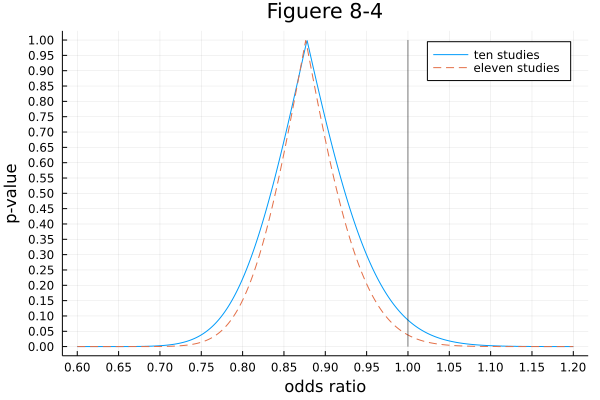

In [7]:
ω = range(0.6, 1.2, 1000)
plot(; title="Figuere 8-4")
plot!(ω, ω -> pval_mantelhaenszel_oddsratio(TenStudies,    ω); label="ten studies")
plot!(ω, ω -> pval_mantelhaenszel_oddsratio(ElevenStudies, ω); label="eleven studies", ls=:dash)
plot!([1, 1], [0, 1]; label="", c=:black, lw=0.5)
plot!(; xtick = range(extrema(ω)...; step=0.05), ytick = 0:0.05:1)
plot!(; xlabel="odds ratio", ylabel="p-value")

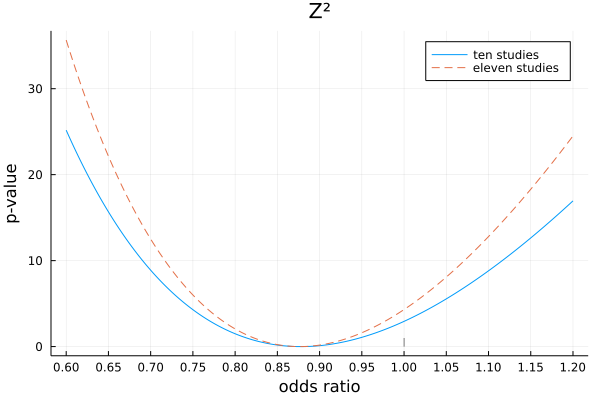

In [8]:
ω = range(0.6, 1.2, 1000)
plot(; title="Z²")
plot!(ω, ω -> zsqstat_oddsratio(TenStudies,    ω); label="ten studies")
plot!(ω, ω -> zsqstat_oddsratio(ElevenStudies, ω); label="eleven studies", ls=:dash)
plot!([1, 1], [0, 1]; label="", c=:black, lw=0.5)
plot!(; xtick = range(extrema(ω)...; step=0.05))
plot!(; xlabel="odds ratio", ylabel="p-value")

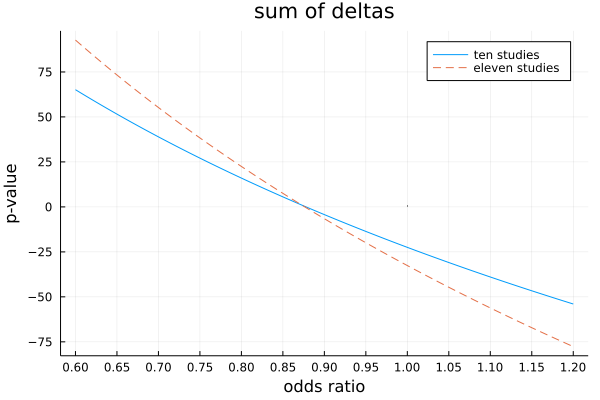

In [9]:
ω = range(0.6, 1.2, 1000)
plot(; title="sum of deltas")
plot!(ω, ω -> sumdelta_oddsratio(TenStudies,    ω); label="ten studies")
plot!(ω, ω -> sumdelta_oddsratio(ElevenStudies, ω); label="eleven studies", ls=:dash)
plot!([1, 1], [0, 1]; label="", c=:black, lw=0.5)
plot!(; xtick = range(extrema(ω)...; step=0.05))
plot!(; xlabel="odds ratio", ylabel="p-value")

## 正規分布近似版

共通のオッズ比の推定量を次で定める:

$$
\operatorname{OR} =
\frac
{\ds \sum_{i=1}^r \frac{a_i d_i}{N_i}}
{\ds \sum_{i=1}^r \frac{b_i c_i}{N_i}}
$$

$\log \operatorname{OR}$ の分散の推定量を次で定める:

$$
S^2 =
\frac
{\ds \sum_{i=1}^r \frac{a_i d_i}{N_i} \frac{a_i + d_i}{N_i}}
{\ds 2\left(\sum_{i=1}^r \frac{a_i d_i}{N_i} \right)^2} +
\frac
{\ds \sum_{i=1}^r \left(\frac{a_i d_i}{N_i} \frac{b_i + c_i}{N_i} + \frac{b_i c_i}{N_i} \frac{a_i + d_i}{N_i}\right)}
{\ds 2\left(\sum_{i=1}^r \frac{a_i d_i}{N_i}\right) \left(\sum_{i=1}^r \frac{b_i c_i}{N_i}\right)} +
\frac
{\ds \sum_{i=1}^r \frac{b_i c_i}{N_i} \frac{b_i + c_i}{N_i}}
{\ds 2\left(\sum_{i=1}^r \frac{b_i c_i}{N_i} \right)^2}.
$$

そして, $\log\operatorname{OR}$ が平均 $\log\omega$, 分散 $S^2$ の正規分布に近似的に従うとみなして, 「共通のオッズ比が $\omega$ である」という仮説のP値を定義する.

In [10]:
function logOR_and_SE(a, b, c, d)
    abcd = zip(a, b, c, d)
    AD = sum(((a, b, c, d),) -> a*d/(a+b+c+d), abcd)
    BC = sum(((a, b, c, d),) -> b*c/(a+b+c+d), abcd)
    logOR = log(AD) - log(BC)
    ADAD = sum(((a, b, c, d),) -> a*d*(a+d)/(a+b+c+d)^2, abcd)
    ADBC = sum(((a, b, c, d),) -> (a*d*(b+c) + b*c*(a+d))/(a+b+c+d)^2, abcd)
    BCBC = sum(((a, b, c, d),) -> b*c*(b+c)/(a+b+c+d)^2, abcd)
    SE² = ADAD/(2AD^2) + ADBC/(2(AD*BC)) + BCBC/(2BC^2)
    SE = √SE²
    (; logOR, SE)
end

@memoize function logOR_and_SE(tbl::Matrix)
    @views a, b, c, d = tbl[:,1], tbl[:,2], tbl[:,3], tbl[:,4]
    logOR_and_SE(a, b, c, d)
end

@memoize function logOR_and_SE(tbl::Array{T, 3} where T)
    @views a, b, c, d = tbl[:,1,1], tbl[:,2,1], tbl[:,2,1], tbl[:,2,2]
    logOR_and_SE(a, b, c, d)
end

function pval_mantelhaenszel_oddsratio_normalapprox(tbl, ω = 1.0)
    (; logOR, SE) = logOR_and_SE(tbl)
    normal = Normal(logOR, SE)
    p_value = min(1, 2cdf(normal, log(ω)), 2ccdf(normal, log(ω)))
end

function ci_mantelhaenszel_oddsratio_normalapprox(tbl, α = 0.05)
    (; logOR, SE) = logOR_and_SE(tbl)
    normal = Normal(logOR, SE)
    conf_int = exp.(quantile.(normal, (α/2, 1 - α/2)))
end

function mantelhaenszel_oddsratio_normalapprox(tbl; ω₀ = 1.0, α = 0.05)
    (; logOR, SE) = logOR_and_SE(tbl)
    odds_ratio = exp(logOR)
    normal = Normal(logOR, SE)
    p_value = min(1, 2cdf(normal, log(ω₀)), 2ccdf(normal, log(ω₀)))
    conf_int = exp.(quantile.(normal, (α/2, 1 - α/2)))
    (; odds_ratio, ω₀, p_value, α, conf_int)
end

mantelhaenszel_oddsratio_normalapprox (generic function with 1 method)

In [11]:
mantelhaenszel_oddsratio_normalapprox(ElevenStudies)

(odds_ratio = 0.876565283202828, ω₀ = 1.0, p_value = 0.03831919505862805, α = 0.05, conf_int = (0.7738329501187073, 0.9929361312394169))

In [12]:
mantelhaenszel_oddsratio(ElevenStudies)

(odds_ratio = 0.8763754526900092, ω₀ = 1.0, p_value = 0.037876956707385036, α = 0.05, conf_int = (0.7737258422531788, 0.9926435960137233))

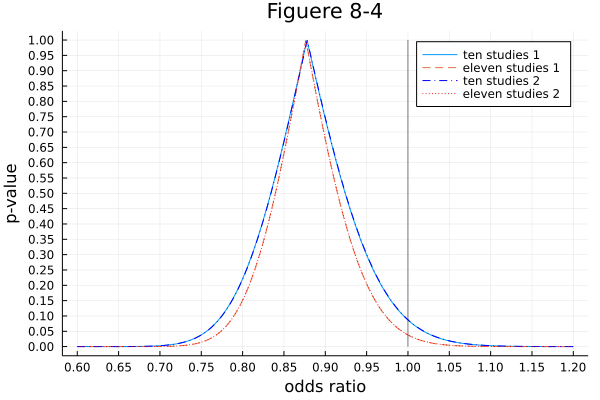

In [13]:
ω = range(0.6, 1.2, 1000)
plot(; title="Figuere 8-4")
plot!(ω, ω -> pval_mantelhaenszel_oddsratio(TenStudies,    ω); label="ten studies 1")
plot!(ω, ω -> pval_mantelhaenszel_oddsratio(ElevenStudies, ω); label="eleven studies 1", ls=:dash)
plot!(ω, ω -> pval_mantelhaenszel_oddsratio_normalapprox(TenStudies,    ω); label="ten studies 2", c=:blue, ls=:dashdot)
plot!(ω, ω -> pval_mantelhaenszel_oddsratio_normalapprox(ElevenStudies, ω); label="eleven studies 2", c=:red, ls=:dot)
plot!([1, 1], [0, 1]; label="", c=:black, lw=0.5)
plot!(; xtick = range(extrema(ω)...; step=0.05), ytick = 0:0.05:1)
plot!(; xlabel="odds ratio", ylabel="p-value")